In [30]:
import numpy as np
import matplotlib.pyplot as plt
from discrete_states import compute_bins, converge_state
from tqdm import tqdm as _tqdm
from windy_gridworld import WindyGridworldEnv
from gridworld import GridworldEnv
from collections import defaultdict
import random
from abc import abstractmethod
import gym

import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from neural_nets import QNetwork, ModelNetwork
from helpers import q_learning, is_done, ReplayMemory, get_epsilon, smooth
from model import DynaQ, TabularDynaQ, DeepDynaQ

env = gym.envs.make("CartPole-v0")
seed = 1

random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)



[1]

# Deep Q-network

In [31]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        
        return self.l2(torch.relu(self.l1(x)))
    
def select_action(model, state, epsilon):
    random_number = random.uniform(0, 1)
    if random_number < epsilon:
        a = random.choice([0, 1])
    else:
        x = torch.FloatTensor(state)
        with torch.no_grad():
            a = model(x).argmax().item()
    return a


def compute_q_val(model, state, action):
    action_values = model(state)
    return action_values[torch.arange(0, state.size(0)), action]
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    
    # calculate Q values next state for batch
    action_values = model(next_state)  # [B, 2]
    
    # get max action values for batch
    max_action_values, _ = action_values.max(dim=1)
    
    # calculate targets
    targets = reward + discount_factor * max_action_values
    
    # targets for terminal state equals 0
    targets[(done == 1)] = 0
    
    return targets

def train(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item() 


def run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        
        # sample a transition
        s = env.reset()
        duration = 0
        done = False
        while not done:
            
            a = select_action(model, s, epsilon=get_epsilon(global_steps))
            s_next, r, done, _ = env.step(a)

            # Push a transition
            memory.push((s, a, r, s_next, done))
            duration += 1
            s = s_next
            
            # train model for a step
            train(model, memory, optimizer, batch_size, discount_factor)
            global_steps += 1
            
        episode_durations.append(duration)
        
    return episode_durations, global_steps

def test_greedy(model, env, num_episodes, discount_factor, learn_rate):
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    
    for i in range(num_episodes):
        
        # sample a transition
        s = env.reset()
        duration = 0
        done = False
        while not done:
            
            a = select_action(model, s, epsilon=0)
            s_next, r, done, _ = env.step(a)

            # Push a transition
            duration += 1
            s = s_next
            
            # train model for a step
#             train(model, memory, optimizer, batch_size, discount_factor)
            global_steps += 1
            
        episode_durations.append(duration)
        
    return episode_durations, np.mean(np.array(episode_durations))







In [63]:
# Let's run it!
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducability
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)
QN_learning, steps = run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)
QN_greedy, mean_duration = test_greedy(model, env, 100, discount_factor, learn_rate)


Capacity:  10000


# Tabular Dyna Q and Deep Dyna-Q 

In [64]:
# Dyna Q
n = 10
learning_rate = 0.5
discount_factor = .8
capacity = 10000
experience_replay = True
true_gradient = False
batch_size = 64
model_batch = False

In [65]:
# Tabular Dyna Q
title = 'Episode lengths Tabular Dyna-Q'
tab_dynaQ = TabularDynaQ(env, n, discount_factor, lr=learning_rate, epsilon=0.2, deterministic=False)
tab_dynaQ.learn_policy(1000)



100%|██████████| 1000/1000 [00:00<00:00, 1211.15it/s]


In [66]:
# Deep Dyna Q
memory = ReplayMemory(capacity)
deep_dynaQ = DeepDynaQ(env, planning_steps=n, discount_factor=discount_factor, lr=1e-3, epsilon=None, memory=memory, experience_replay=experience_replay, true_gradient=true_gradient, batch_size=batch_size, model_batch=model_batch)
deep_dynaQ.learn_policy(1000)


  3%|▎         | 27/1000 [00:00<00:03, 249.55it/s]

Capacity:  10000


100%|██████████| 1000/1000 [00:16<00:00, 72.54it/s]


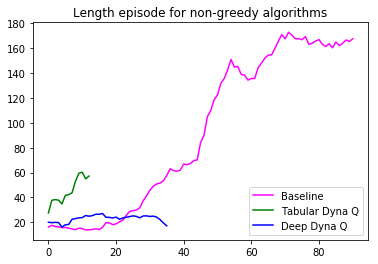

In [67]:
# make plots
plt.plot(smooth(QN_learning, 10), 'magenta', label = 'Baseline')
plt.plot(smooth(tab_dynaQ.episode_lengths, 10), 'green', label = "Tabular Dyna Q")
plt.plot(smooth(deep_dynaQ.episode_lengths, 10), 'blue', label = "Deep Dyna Q")
plt.legend(loc='lower right')
non_greedy_title = 'Length episode for non-greedy algorithms'
plt.title(non_greedy_title)  # NB: lengths == returns
plt.show()



100%|██████████| 100/100 [00:02<00:00, 44.14it/s]


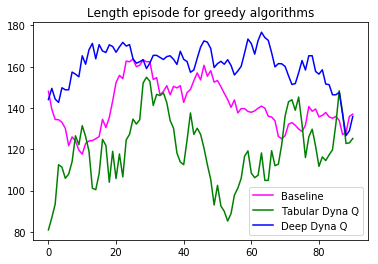

In [68]:

# Test the models

tab_dynaQ.test_model_greedy(100)
deep_dynaQ.test_model_greedy(100)

# plot the test results
plt.plot(smooth(QN_greedy, 10), 'magenta', label = 'Baseline')
plt.plot(smooth(tab_dynaQ.episode_lengths, 10), 'green', label = "Tabular Dyna Q")
plt.plot(smooth(deep_dynaQ.episode_lengths,10), 'blue', label = "Deep Dyna Q")
plt.legend(loc = 'lower right')
greedy_title = 'Length episode for greedy algorithms'
plt.title(greedy_title)  # NB: lengths == returns
plt.show()